# Visualization of differences in protein intensities across various samples

In [7]:
library(DEVis)
# load libraries (this gets ggplot2 and related libraries)
library(tidyverse)

library("RColorBrewer")
install.packages("gplots")
library(gplots)

# these are from Bioconductor
library(limma) 
library(edgeR) 
library(sva)

library(ggpubr)



Installing package into 'C:/Users/conar/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'gplots' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\conar\AppData\Local\Temp\RtmpOUOIlQ\downloaded_packages


Warning message:
"package 'gplots' was built under R version 3.6.3"
Attaching package: 'gplots'

The following object is masked from 'package:IRanges':

    space

The following object is masked from 'package:S4Vectors':

    space

The following object is masked from 'package:stats':

    lowess



### Load dataset

In [2]:
comp_df = read.csv(file='../Intermediate data/labeled_IRS_proteins_GO.csv')

### Generate a volcano plot to show the differences in individual protein intensities between each experimental condition compared to the BL-E control.
##### The thresholds set for labeling a protein as increased or decreased are a change of 25% in mean intensity and a p-value < 0.01.

[1] 0.3219281
[1] 2


`mutate_all()` ignored the following grouping variables:
Column `ex_name`
Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


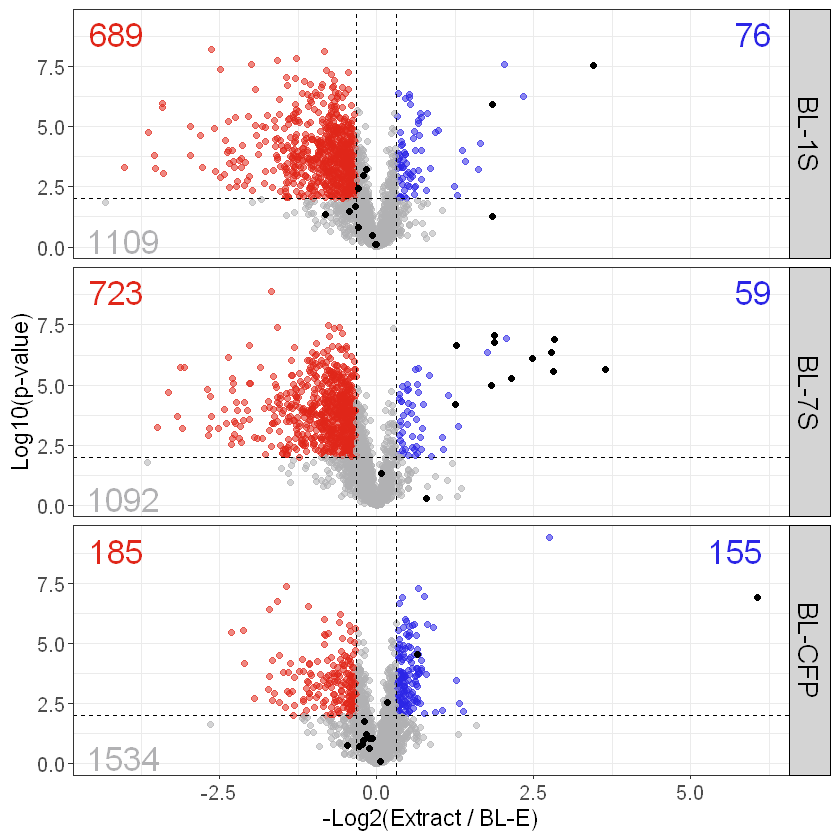

In [3]:
CHANGE_THRESHOLD = 1.25
P_VALUE_THRESHOLD = 0.01

fc_limit = log2(CHANGE_THRESHOLD)
p_val_limit = -log10(P_VALUE_THRESHOLD)

shaped_full = comp_df %>%
    gather('CF_BL_fc','S1_BL_fc','S7_BL_fc',
           key='sample_id',value='fc') %>%
    gather('CF_BL_p_val','S1_BL_p_val','S7_BL_p_val',
           key='sample_p_id',value='p_val') %>%
    mutate(log_p = -log10(p_val),
           log_2_fc = log2(fc),
           fc_ext = str_sub(sample_id,1,2),
           p_ext = str_sub(sample_p_id,1,2),) %>%
    filter(fc_ext == p_ext)

shaped_full = shaped_full %>%
    mutate(ex_name = dplyr::case_when(shaped_full$fc_ext == "CF" ~ "BL-CFP", 
                                      shaped_full$fc_ext == "S1" ~ "BL-1S",
                                      shaped_full$fc_ext == "S7" ~ "BL-7S",
                                      TRUE ~ "Unknown"))

counts = shaped_full %>%
    mutate(diff = dplyr::case_when(shaped_full$log_2_fc < -1*fc_limit & shaped_full$log_p > p_val_limit ~ "Low", 
                                      shaped_full$log_2_fc > fc_limit & shaped_full$log_p > p_val_limit  ~ "High",
                                      TRUE ~ "Unchanged")) %>%
    group_by(ex_name,diff) %>%
    summarize(n())

export_data = shaped_full %>%
    mutate(diff = dplyr::case_when(shaped_full$log_2_fc < -1*fc_limit & shaped_full$log_p > p_val_limit ~ "Low", 
                                      shaped_full$log_2_fc > fc_limit & shaped_full$log_p > p_val_limit  ~ "High",
                                      TRUE ~ "Unchanged"))
all_counts = counts %>%
    mutate_all(as.character)

colnames(all_counts)[colnames(all_counts)=="n()"] <- "value"

all_vol = shaped_full %>%
    ggplot(aes(x=log_2_fc,y=log_p)) +
    geom_point(aes(alpha=0.2),color = dplyr::case_when(shaped_full$log_2_fc < -1*fc_limit & shaped_full$log_p > p_val_limit ~ "#e02619", 
                                      shaped_full$log_2_fc > fc_limit & shaped_full$log_p > p_val_limit  ~ "#2b25e6",
                                      TRUE ~ "#b1b1b3")) +
    geom_point(data=filter(shaped_full, expressed == 'exp'),
               aes(x=log_2_fc,y=log_p),
               color='black',) +
    geom_hline(
        yintercept = p_val_limit,
        col = "black",
        linetype = "dashed",
        size = 0.5) +
    geom_vline(
        xintercept = -1*fc_limit,
        col = "black",
        linetype = "dashed",
        size = 0.5) +
    geom_vline(
        xintercept = fc_limit,
        col = "black",
        linetype = "dashed",
        size = 0.5) +
    facet_grid(rows = vars(ex_name)) +
    geom_text(
      data    = subset(all_counts, diff == "Low"),
      mapping = aes(x = -Inf, y = Inf, label = value),
      hjust   = -0.3,
      vjust   = 1.5,
      colour  = '#e02619',
      size    = 7
    ) +
    geom_text(
      data    = subset(all_counts, diff == "High"),
      mapping = aes(x = Inf, y = Inf, label = value),
      hjust   = 1.5,
      vjust   = 1.5,
      colour  = '#2b25e6',
      size    = 7
    ) +
    geom_text(
      data    = subset(all_counts, diff == "Unchanged"),
      mapping = aes(x = -Inf, y = -Inf, label = value),
      hjust   = -0.2,
      vjust   = -0.2,
      colour  = '#b1b1b3',
      size    = 7
    ) +
    xlab("-Log2(Extract / BL-E)") +
    ylab("Log10(p-value)") +

    scale_alpha(guide = 'none') +

    theme_bw() + 
    theme(
        strip.text.y = element_text(
            size = 16, color = "Black"),
        strip.background = element_rect(
             color="black", fill="#d4d4d4", size=0.5, linetype="solid"),
        axis.text=element_text(size=12),
        axis.title=element_text(size=14)
        )
all_vol

### Generate a stacked bar graph to illustrate the relative abundance of protein in each general category

Warning message:
"Setting row names on a tibble is deprecated."

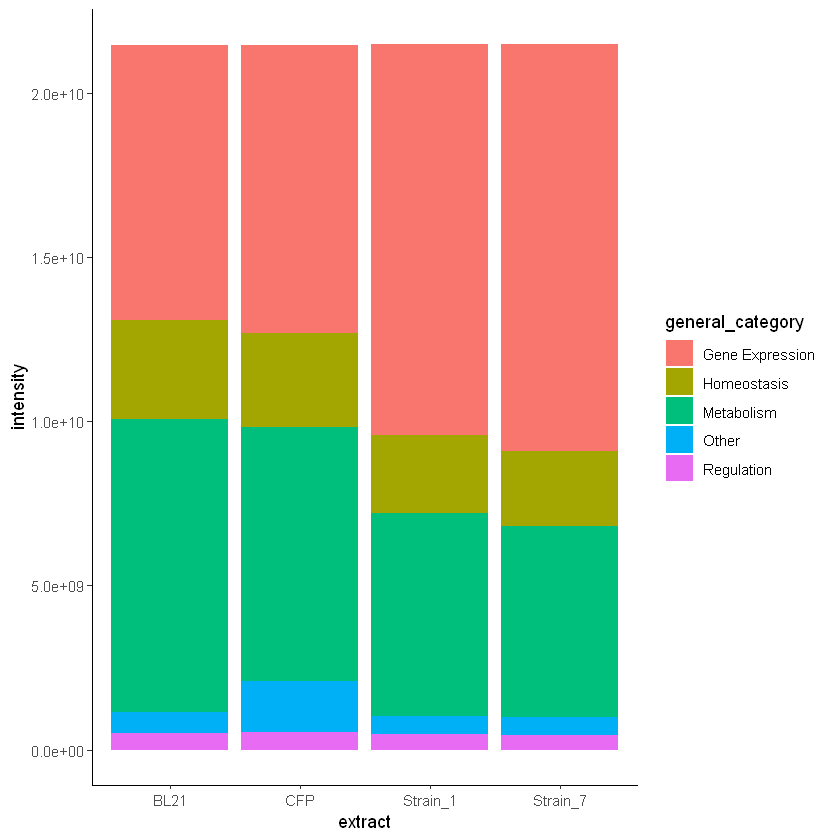

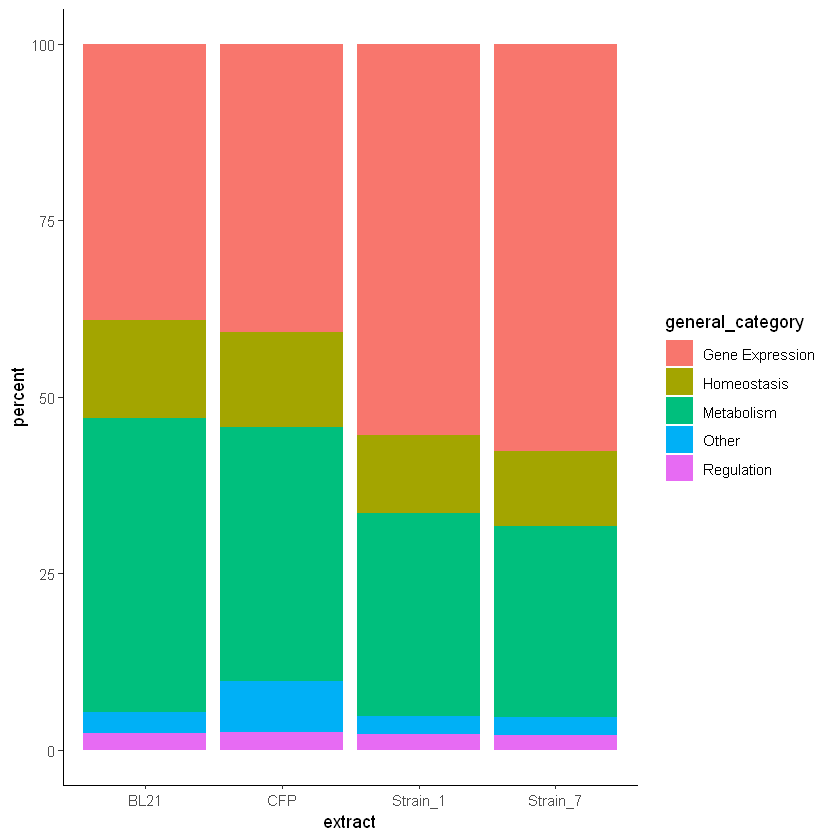

In [6]:
shaped = comp_df %>%
    gather('BL_mean','CF_mean','S1_mean','S7_mean',
           key='sample_id',value='intensity')

ex_group = shaped %>%
    group_by(sample_id, general_category) %>%
    summarize(sum_protein = sum(intensity))

div = ex_group %>%
    spread(sample_id, sum_protein) %>%
    mutate(BL21 = BL_mean,
           CFP = CF_mean,
           Strain_1 = S1_mean,
           Strain_7 = S7_mean) %>%
    select(general_category,BL21,CFP,Strain_1,Strain_7) %>%
    gather('BL21','CFP','Strain_1','Strain_7',
           key='extract',value='intensity') %>%
    spread(general_category, intensity)

rownames(div) = div$extract
div = select(div,-extract)

sums = rowSums(div)
div2 = cbind(div,sums)
div2 = tibble::rownames_to_column(div2, "extract")


## Generate a plot with protein intensity values
div_shape = div2 %>%
    gather(colnames(div),
           key='general_category',value='intensity') %>%
    select(-sums)

stack = div_shape %>%
    ggplot(aes(x=extract, y=intensity, fill=general_category,label=intensity)) + 
    geom_bar(stat='identity') +
    theme_classic()

stack

## Generate a plot with percent of total protein intensity values
div_shape = div2 %>%
    gather(colnames(div),
           key='general_category',value='intensity') %>%
    mutate(percent = intensity/sums*100,
           round_per = round(percent,0)) %>%
    select(-sums,-intensity)


stack = div_shape %>%
    ggplot(aes(x=extract, y=percent, fill=general_category,label=round_per)) + 
    geom_bar(stat='identity') +
    theme_classic()
    
stack


### Generation of a heatmap to illustrate the differences in the log fold changes of each protein compared to the control within each specific category

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."

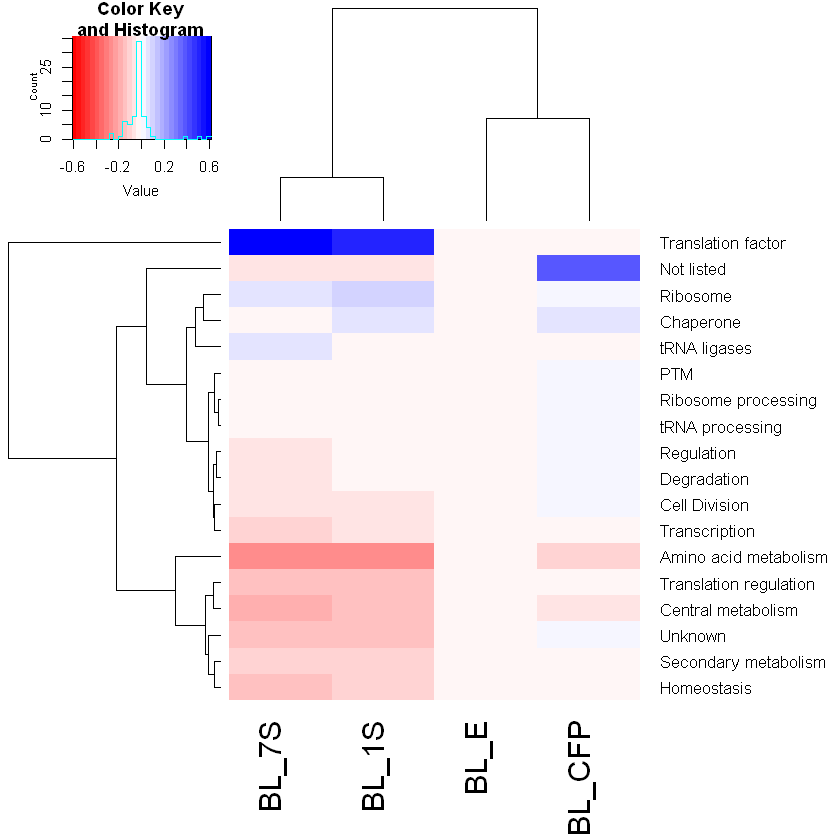

In [9]:
shaped = comp_df %>%
    gather('BL_mean','CF_mean','S1_mean','S7_mean',
           key='sample_id',value='intensity')

ex_group = shaped %>%
    group_by(sample_id, category) %>%
    summarize(mean_protein = mean(intensity,na.rm=TRUE)) #/group_by(filter(shaped, sample_id == 'pool_mean'))

div = ex_group %>%
    spread(sample_id, mean_protein) %>%
    mutate(BL_E = log10(BL_mean/BL_mean),
           BL_CFP = log10(CF_mean/BL_mean),
           BL_1S = log10(S1_mean/BL_mean),
           BL_7S = log10(S7_mean/BL_mean)) %>%
    select(category,BL_E,BL_CFP,BL_1S,BL_7S) %>%
    gather('BL_E','BL_CFP','BL_1S','BL_7S',
           key='extract',value='intensity') %>%
    spread(category, intensity)

rownames(div) = div$extract
div.num = div[,2:ncol(div)]
rownames(div.num) = div$extract

colfunc <- colorRampPalette(c("red","white","blue"))

fc_df = mutate_all(div.num,funs('fc' = round((10^.)*100,0)))
heatmap.2(as.matrix(t(div.num)),
        col=colfunc(30),
        scale='none',
        symbreaks=TRUE,
        margins=c(7,10),
        trace='none')
